# Week 13 - Day 3: Regularization Techniques for Trading Models

## Learning Objectives
- Understand why overfitting is particularly dangerous in financial models
- Implement L1 (Lasso) and L2 (Ridge) weight regularization in PyTorch
- Master Dropout for neural network regularization
- Compare Batch Normalization vs Layer Normalization for trading applications
- Implement Early Stopping with patience-based callbacks
- Build a fully regularized MLP for SPY price prediction

## European Market Context
European quantitative trading firms like **Man AHL**, **Winton Group**, and **CFM** place enormous emphasis on model robustness. The European Securities and Markets Authority (ESMA) requires algorithmic trading firms to demonstrate model validation procedures, making regularization not just a best practice but a regulatory consideration.

---

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn for preprocessing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Using device: cpu


---

## 2. Why Overfitting is Critical in Trading

### The Overfitting Problem in Finance

Overfitting in trading models is **far more dangerous** than in typical ML applications:

| Issue | Impact in Trading |
|-------|------------------|
| **Capital Loss** | Overfit models lose real money when deployed |
| **Non-stationarity** | Financial markets change regime frequently |
| **Low Signal-to-Noise** | True alpha signals are weak, noise is abundant |
| **Multiple Testing** | Trying many strategies inflates false discovery rate |
| **Transaction Costs** | Overfit models often overtrade, destroying returns |

### The Fundamental Law of Active Management

$$IR = IC \times \sqrt{BR}$$

Where:
- **IR** = Information Ratio (risk-adjusted return)
- **IC** = Information Coefficient (prediction accuracy)
- **BR** = Breadth (number of independent bets)

Overfit models have **inflated IC in-sample** but **near-zero IC out-of-sample**.

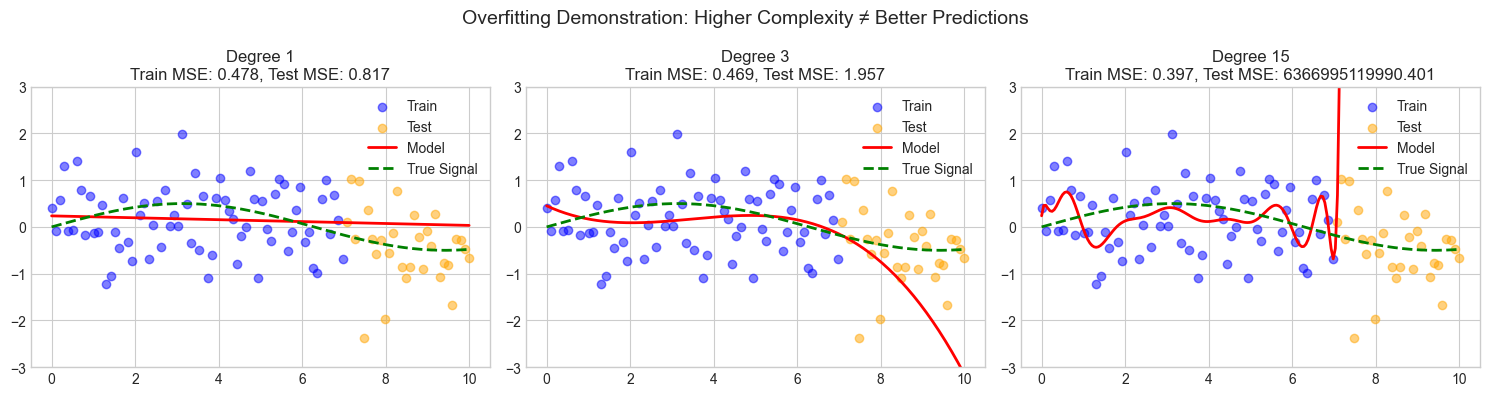


📊 Key Insight: The degree-15 polynomial perfectly fits training data but fails catastrophically on test data.
   In trading, this translates to: Great backtest → Terrible live performance → Lost capital


In [2]:
# Demonstration: Overfitting with polynomial features
np.random.seed(42)

# Generate synthetic "market returns" with weak signal
n_samples = 100
X_demo = np.linspace(0, 10, n_samples)
true_signal = 0.5 * np.sin(X_demo * 0.5)  # True weak signal
noise = np.random.normal(0, 0.8, n_samples)  # High noise (low SNR)
y_demo = true_signal + noise

# Split data
split_idx = 70
X_train_demo, X_test_demo = X_demo[:split_idx], X_demo[split_idx:]
y_train_demo, y_test_demo = y_demo[:split_idx], y_demo[split_idx:]

# Fit polynomials of different degrees
degrees = [1, 3, 15]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, degree in zip(axes, degrees):
    # Fit polynomial
    coeffs = np.polyfit(X_train_demo, y_train_demo, degree)
    poly = np.poly1d(coeffs)
    
    # Predictions
    y_train_pred = poly(X_train_demo)
    y_test_pred = poly(X_test_demo)
    
    # Calculate errors
    train_mse = mean_squared_error(y_train_demo, y_train_pred)
    test_mse = mean_squared_error(y_test_demo, y_test_pred)
    
    # Plot
    ax.scatter(X_train_demo, y_train_demo, alpha=0.5, label='Train', c='blue')
    ax.scatter(X_test_demo, y_test_demo, alpha=0.5, label='Test', c='orange')
    
    X_smooth = np.linspace(0, 10, 200)
    ax.plot(X_smooth, poly(X_smooth), 'r-', linewidth=2, label='Model')
    ax.plot(X_smooth, 0.5 * np.sin(X_smooth * 0.5), 'g--', linewidth=2, label='True Signal')
    
    ax.set_title(f'Degree {degree}\nTrain MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}')
    ax.legend()
    ax.set_ylim(-3, 3)

plt.suptitle('Overfitting Demonstration: Higher Complexity ≠ Better Predictions', fontsize=14)
plt.tight_layout()
plt.show()

print("\n📊 Key Insight: The degree-15 polynomial perfectly fits training data but fails catastrophically on test data.")
print("   In trading, this translates to: Great backtest → Terrible live performance → Lost capital")

---

## 3. Load and Prepare SPY Data

In [3]:
# Download SPY data
print("Downloading SPY data...")
spy = yf.download('SPY', start='2015-01-01', end='2024-12-31', progress=False)

# Use Close prices
df = pd.DataFrame()
df['Close'] = spy['Close'].squeeze()

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
df.head()

Data shape: (2515, 1)
Date range: 2015-01-02 00:00:00 to 2024-12-30 00:00:00


,Close
Date,
2015-01-02,170.589600
2015-01-05,167.508789
2015-01-06,165.931015
2015-01-07,167.998810
2015-01-08,170.979904


In [4]:
# Feature Engineering for SPY prediction
def create_features(df, lookback_periods=[1, 5, 10, 21, 63]):
    """
    Create technical features for price prediction.
    
    Features:
    - Returns at various lookback periods
    - Volatility measures
    - Momentum indicators
    - Price ratios
    """
    data = df.copy()
    close = data['Close']
    
    # Returns at different horizons
    for period in lookback_periods:
        data[f'return_{period}d'] = close.pct_change(period)
    
    # Volatility (realized)
    for period in [5, 10, 21]:
        data[f'volatility_{period}d'] = close.pct_change().rolling(period).std() * np.sqrt(252)
    
    # Moving average ratios
    for period in [5, 10, 21, 50]:
        data[f'ma_ratio_{period}d'] = close / close.rolling(period).mean() - 1
    
    # RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    data['rsi_14'] = 100 - (100 / (1 + rs))
    
    # Bollinger Band position
    ma20 = close.rolling(20).mean()
    std20 = close.rolling(20).std()
    data['bb_position'] = (close - ma20) / (2 * std20)
    
    # Target: Next day return
    data['target'] = close.pct_change().shift(-1)
    
    # Drop NaN values
    data = data.dropna()
    
    return data

# Create features
df_features = create_features(df)
print(f"Features created: {df_features.shape[1] - 2} features")  # -2 for Close and target
print(f"Samples available: {len(df_features)}")

# Display feature names
feature_cols = [col for col in df_features.columns if col not in ['Close', 'target']]
print(f"\nFeature columns: {feature_cols}")

Features created: 14 features
Samples available: 2451

Feature columns: ['return_1d', 'return_5d', 'return_10d', 'return_21d', 'return_63d', 'volatility_5d', 'volatility_10d', 'volatility_21d', 'ma_ratio_5d', 'ma_ratio_10d', 'ma_ratio_21d', 'ma_ratio_50d', 'rsi_14', 'bb_position']


In [5]:
# Prepare data for PyTorch
X = df_features[feature_cols].values
y = df_features['target'].values

# Time-series split (no shuffling to respect temporal order)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"\nInput dimension: {X_train.shape[1]}")

Training samples: 1715
Validation samples: 367
Test samples: 369

Input dimension: 14


---

## 4. L1 and L2 Weight Regularization

### Theory

**L2 Regularization (Ridge / Weight Decay)**:
$$\mathcal{L}_{total} = \mathcal{L}_{data} + \lambda \sum_{i} w_i^2$$

- Penalizes large weights
- Encourages small, distributed weights
- Does NOT produce sparse solutions

**L1 Regularization (Lasso)**:
$$\mathcal{L}_{total} = \mathcal{L}_{data} + \lambda \sum_{i} |w_i|$$

- Encourages sparsity (many weights become exactly zero)
- Useful for feature selection
- Can be combined with L2 (Elastic Net)

### Trading Context
- **L2**: Preferred when all features may contain signal
- **L1**: Useful when you suspect many features are noise (common in finance)

In [6]:
class MLPWithRegularization(nn.Module):
    """
    MLP with configurable L1/L2 regularization.
    Note: L2 is typically handled by optimizer weight_decay,
    but we implement both explicitly for educational purposes.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32], output_dim=1):
        super(MLPWithRegularization, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
    def l1_regularization(self):
        """Calculate L1 norm of all weights."""
        l1_norm = 0
        for param in self.parameters():
            l1_norm += torch.sum(torch.abs(param))
        return l1_norm
    
    def l2_regularization(self):
        """Calculate L2 norm of all weights."""
        l2_norm = 0
        for param in self.parameters():
            l2_norm += torch.sum(param ** 2)
        return l2_norm


def train_with_regularization(model, train_loader, val_loader, epochs=100, 
                              lr=0.001, l1_lambda=0, l2_lambda=0, verbose=True):
    """
    Training loop with explicit L1/L2 regularization.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(X_batch)
            data_loss = criterion(predictions, y_batch)
            
            # Add regularization
            reg_loss = l1_lambda * model.l1_regularization() + l2_lambda * model.l2_regularization()
            total_loss = data_loss + reg_loss
            
            # Backward pass
            total_loss.backward()
            optimizer.step()
            
            epoch_train_loss += data_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                val_loss += criterion(predictions, y_batch).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if verbose and (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    return train_losses, val_losses

print("✓ MLPWithRegularization class defined")

✓ MLPWithRegularization class defined


In [7]:
# Compare: No regularization vs L1 vs L2
input_dim = X_train.shape[1]

# Train models with different regularization
configs = [
    {'name': 'No Regularization', 'l1': 0, 'l2': 0},
    {'name': 'L1 (λ=1e-5)', 'l1': 1e-5, 'l2': 0},
    {'name': 'L2 (λ=1e-4)', 'l1': 0, 'l2': 1e-4},
    {'name': 'Elastic Net (L1+L2)', 'l1': 1e-5, 'l2': 1e-4},
]

results = {}
epochs = 100

for config in configs:
    print(f"\nTraining: {config['name']}")
    model = MLPWithRegularization(input_dim, hidden_dims=[64, 32]).to(device)
    train_losses, val_losses = train_with_regularization(
        model, train_loader, val_loader, 
        epochs=epochs, l1_lambda=config['l1'], l2_lambda=config['l2'],
        verbose=False
    )
    results[config['name']] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'model': model
    }
    print(f"  Final Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")


Training: No Regularization
  Final Train Loss: 0.000065, Val Loss: 0.000318

Training: L1 (λ=1e-5)
  Final Train Loss: 0.000114, Val Loss: 0.000180

Training: L2 (λ=1e-4)
  Final Train Loss: 0.000109, Val Loss: 0.000176

Training: Elastic Net (L1+L2)
  Final Train Loss: 0.000124, Val Loss: 0.000178


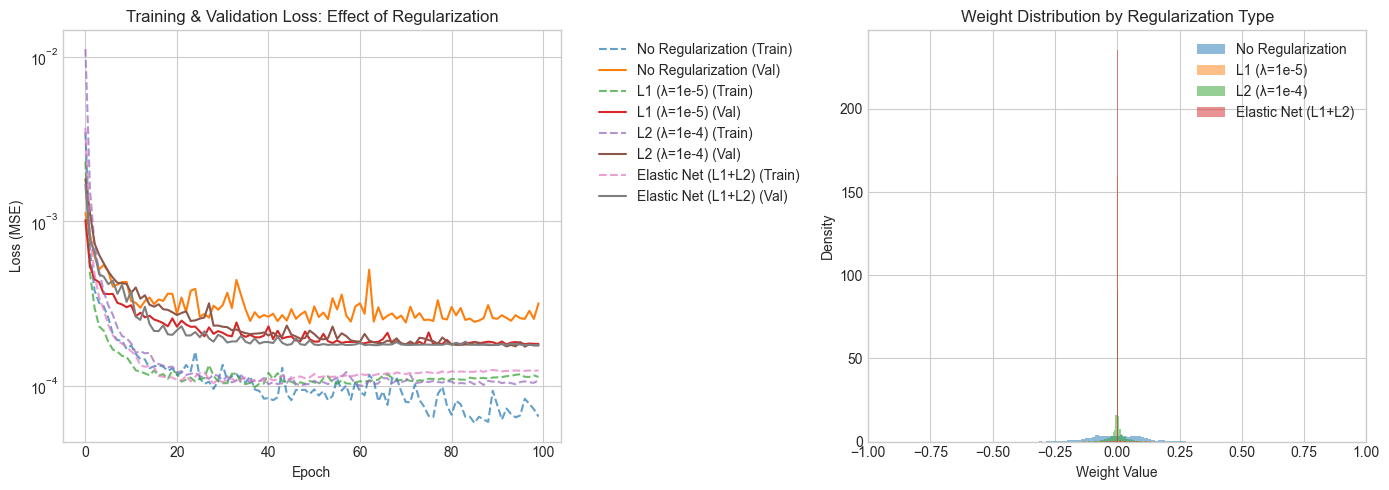


📊 Key Observations:
   • L1 regularization pushes weights towards zero (promotes sparsity)
   • L2 regularization creates a tighter distribution around zero
   • No regularization allows weights to grow larger, potentially overfitting


In [8]:
# Visualize regularization effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training curves
ax1 = axes[0]
for name, result in results.items():
    ax1.plot(result['train_losses'], label=f'{name} (Train)', linestyle='--', alpha=0.7)
    ax1.plot(result['val_losses'], label=f'{name} (Val)')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training & Validation Loss: Effect of Regularization')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_yscale('log')

# Plot 2: Weight distributions
ax2 = axes[1]
for name, result in results.items():
    weights = []
    for param in result['model'].parameters():
        weights.extend(param.detach().cpu().numpy().flatten())
    ax2.hist(weights, bins=50, alpha=0.5, label=name, density=True)

ax2.set_xlabel('Weight Value')
ax2.set_ylabel('Density')
ax2.set_title('Weight Distribution by Regularization Type')
ax2.legend()
ax2.set_xlim(-1, 1)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("   • L1 regularization pushes weights towards zero (promotes sparsity)")
print("   • L2 regularization creates a tighter distribution around zero")
print("   • No regularization allows weights to grow larger, potentially overfitting")

---

## 5. Dropout Implementation

### Theory

**Dropout** randomly sets a fraction of neurons to zero during training:

$$h' = \text{mask} \odot h \cdot \frac{1}{1-p}$$

Where:
- $p$ = dropout probability
- mask = Bernoulli random variable (0 or 1)
- The scaling factor $\frac{1}{1-p}$ ensures expected values match at test time

### Why Dropout Works
1. **Ensemble effect**: Training many "thinned" networks
2. **Reduces co-adaptation**: Neurons can't rely on specific other neurons
3. **Adds noise**: Acts as regularization

### Trading Considerations
- Typical dropout rates: 0.1 - 0.5
- Higher dropout for smaller datasets (common in finance)
- Can be used with Monte Carlo Dropout for uncertainty estimation

In [9]:
class MLPWithDropout(nn.Module):
    """
    MLP with configurable dropout after each hidden layer.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout_rate=0.3, output_dim=1):
        super(MLPWithDropout, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_rate))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
        self.dropout_rate = dropout_rate
    
    def forward(self, x):
        return self.network(x)
    
    def predict_with_uncertainty(self, x, n_samples=100):
        """
        Monte Carlo Dropout for uncertainty estimation.
        Keep dropout active during inference.
        """
        self.train()  # Enable dropout
        predictions = []
        
        with torch.no_grad():
            for _ in range(n_samples):
                pred = self.forward(x)
                predictions.append(pred.cpu().numpy())
        
        predictions = np.array(predictions)
        mean_pred = predictions.mean(axis=0)
        std_pred = predictions.std(axis=0)
        
        self.eval()  # Reset to eval mode
        return mean_pred, std_pred


def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, verbose=True):
    """Standard training loop."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        train_losses.append(epoch_train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                val_loss += criterion(predictions, y_batch).item()
        
        val_losses.append(val_loss / len(val_loader))
        
        if verbose and (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train: {train_losses[-1]:.6f}, Val: {val_losses[-1]:.6f}")
    
    return train_losses, val_losses

print("✓ MLPWithDropout class defined")

✓ MLPWithDropout class defined


In [10]:
# Compare different dropout rates
dropout_rates = [0.0, 0.2, 0.4, 0.5]
dropout_results = {}

for rate in dropout_rates:
    print(f"\nTraining with Dropout Rate: {rate}")
    model = MLPWithDropout(input_dim, hidden_dims=[64, 32], dropout_rate=rate).to(device)
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=100, verbose=False)
    dropout_results[rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'model': model
    }
    print(f"  Final - Train: {train_losses[-1]:.6f}, Val: {val_losses[-1]:.6f}")
    print(f"  Overfitting Gap: {val_losses[-1] - train_losses[-1]:.6f}")


Training with Dropout Rate: 0.0
  Final - Train: 0.000065, Val: 0.000256
  Overfitting Gap: 0.000191

Training with Dropout Rate: 0.2
  Final - Train: 0.000102, Val: 0.000180
  Overfitting Gap: 0.000078

Training with Dropout Rate: 0.4
  Final - Train: 0.000134, Val: 0.000177
  Overfitting Gap: 0.000043

Training with Dropout Rate: 0.5
  Final - Train: 0.000128, Val: 0.000178
  Overfitting Gap: 0.000051


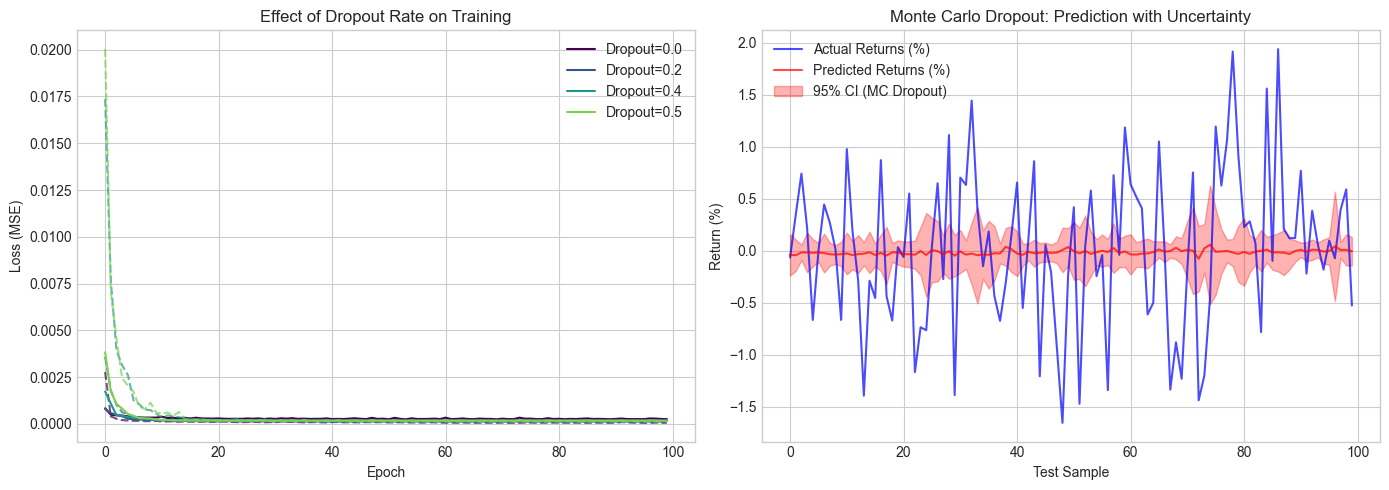


📊 Monte Carlo Dropout Insight:
   • Wider uncertainty bands indicate predictions the model is less confident about
   • This is valuable for position sizing: smaller positions when uncertainty is high


In [11]:
# Visualize dropout effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training curves
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(dropout_rates)))

for i, (rate, result) in enumerate(dropout_results.items()):
    ax1.plot(result['train_losses'], color=colors[i], linestyle='--', alpha=0.7)
    ax1.plot(result['val_losses'], color=colors[i], label=f'Dropout={rate}')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Effect of Dropout Rate on Training')
ax1.legend()

# Plot 2: Monte Carlo Dropout Uncertainty
ax2 = axes[1]

# Use model with dropout=0.4 for MC dropout demonstration
mc_model = dropout_results[0.4]['model']
mean_preds, std_preds = mc_model.predict_with_uncertainty(X_test_tensor, n_samples=100)

# Plot subset for clarity
subset = 100
x_axis = range(subset)
ax2.plot(x_axis, y_test[:subset] * 100, 'b-', label='Actual Returns (%)', alpha=0.7)
ax2.plot(x_axis, mean_preds[:subset].flatten() * 100, 'r-', label='Predicted Returns (%)', alpha=0.7)
ax2.fill_between(x_axis, 
                  (mean_preds[:subset].flatten() - 2*std_preds[:subset].flatten()) * 100,
                  (mean_preds[:subset].flatten() + 2*std_preds[:subset].flatten()) * 100,
                  alpha=0.3, color='red', label='95% CI (MC Dropout)')

ax2.set_xlabel('Test Sample')
ax2.set_ylabel('Return (%)')
ax2.set_title('Monte Carlo Dropout: Prediction with Uncertainty')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📊 Monte Carlo Dropout Insight:")
print("   • Wider uncertainty bands indicate predictions the model is less confident about")
print("   • This is valuable for position sizing: smaller positions when uncertainty is high")

---

## 6. Batch Normalization vs Layer Normalization

### Batch Normalization (BatchNorm)

Normalizes across the **batch dimension** for each feature:

$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

Where $\mu_B$ and $\sigma_B^2$ are computed across the mini-batch.

**Pros**: Faster training, some regularization effect  
**Cons**: Depends on batch size, different behavior train/test

### Layer Normalization (LayerNorm)

Normalizes across the **feature dimension** for each sample:

$$\hat{x}_i = \frac{x_i - \mu_L}{\sqrt{\sigma_L^2 + \epsilon}}$$

Where $\mu_L$ and $\sigma_L^2$ are computed across features for each sample.

**Pros**: Independent of batch size, consistent train/test  
**Cons**: Slightly slower convergence sometimes

### Trading Recommendation
- **LayerNorm** preferred for trading models due to:
  - Consistent behavior during live trading
  - No batch size dependency
  - Better for online/incremental learning

In [12]:
class MLPWithBatchNorm(nn.Module):
    """MLP with Batch Normalization."""
    def __init__(self, input_dim, hidden_dims=[64, 32], output_dim=1):
        super(MLPWithBatchNorm, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


class MLPWithLayerNorm(nn.Module):
    """MLP with Layer Normalization."""
    def __init__(self, input_dim, hidden_dims=[64, 32], output_dim=1):
        super(MLPWithLayerNorm, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


class MLPNoNorm(nn.Module):
    """MLP without any normalization."""
    def __init__(self, input_dim, hidden_dims=[64, 32], output_dim=1):
        super(MLPNoNorm, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

print("✓ Normalization classes defined")

✓ Normalization classes defined


In [13]:
# Compare normalization techniques
norm_configs = [
    ('No Normalization', MLPNoNorm),
    ('Batch Normalization', MLPWithBatchNorm),
    ('Layer Normalization', MLPWithLayerNorm),
]

norm_results = {}

for name, ModelClass in norm_configs:
    print(f"\nTraining: {name}")
    model = ModelClass(input_dim, hidden_dims=[128, 64, 32]).to(device)
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=100, verbose=False)
    norm_results[name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'model': model
    }
    print(f"  Final - Train: {train_losses[-1]:.6f}, Val: {val_losses[-1]:.6f}")


Training: No Normalization
  Final - Train: 0.000035, Val: 0.000264

Training: Batch Normalization
  Final - Train: 0.000116, Val: 0.000259

Training: Layer Normalization
  Final - Train: 0.000045, Val: 0.000384


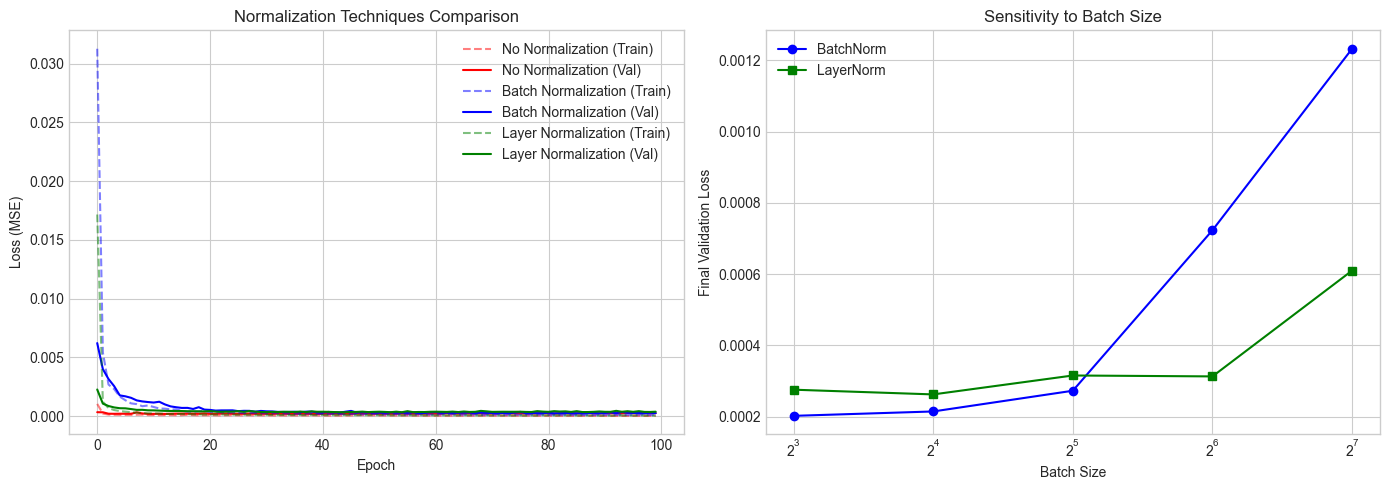


📊 Key Insights:
   • BatchNorm performance varies more with batch size
   • LayerNorm is more stable across different batch sizes
   • For production trading systems, LayerNorm is often preferred


In [14]:
# Visualize normalization comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training curves
ax1 = axes[0]
colors = ['red', 'blue', 'green']

for i, (name, result) in enumerate(norm_results.items()):
    ax1.plot(result['train_losses'], color=colors[i], linestyle='--', alpha=0.5, label=f'{name} (Train)')
    ax1.plot(result['val_losses'], color=colors[i], label=f'{name} (Val)')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Normalization Techniques Comparison')
ax1.legend()

# Plot 2: Batch size sensitivity test
ax2 = axes[1]
batch_sizes = [8, 16, 32, 64, 128]
bn_final_losses = []
ln_final_losses = []

for bs in batch_sizes:
    # Create loader with specific batch size
    temp_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    
    # BatchNorm model
    bn_model = MLPWithBatchNorm(input_dim).to(device)
    _, val_losses = train_model(bn_model, temp_loader, val_loader, epochs=50, verbose=False)
    bn_final_losses.append(val_losses[-1])
    
    # LayerNorm model
    ln_model = MLPWithLayerNorm(input_dim).to(device)
    _, val_losses = train_model(ln_model, temp_loader, val_loader, epochs=50, verbose=False)
    ln_final_losses.append(val_losses[-1])

ax2.plot(batch_sizes, bn_final_losses, 'b-o', label='BatchNorm')
ax2.plot(batch_sizes, ln_final_losses, 'g-s', label='LayerNorm')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Final Validation Loss')
ax2.set_title('Sensitivity to Batch Size')
ax2.legend()
ax2.set_xscale('log', base=2)

plt.tight_layout()
plt.show()

print("\n📊 Key Insights:")
print("   • BatchNorm performance varies more with batch size")
print("   • LayerNorm is more stable across different batch sizes")
print("   • For production trading systems, LayerNorm is often preferred")

---

## 7. Early Stopping

### Concept

**Early Stopping** monitors validation loss and stops training when it stops improving:

1. Track validation loss each epoch
2. If no improvement for `patience` epochs, stop training
3. Restore weights from best epoch

### Why It's Crucial for Trading
- Prevents overfitting without explicit regularization hyperparameter
- Saves computational resources
- Automatically finds optimal training duration

### Implementation Details
- **Patience**: Number of epochs to wait (typically 5-20)
- **Min delta**: Minimum improvement to qualify as improvement
- **Restore best weights**: Critical for final model

In [15]:
class EarlyStopping:
    """
    Early stopping callback for PyTorch training.
    
    Usage:
        early_stopping = EarlyStopping(patience=10, min_delta=1e-6)
        
        for epoch in range(max_epochs):
            train(...)
            val_loss = validate(...)
            
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered")
                break
        
        # Restore best weights
        model.load_state_dict(early_stopping.best_weights)
    """
    
    def __init__(self, patience=10, min_delta=0, verbose=True):
        """
        Args:
            patience: Number of epochs to wait for improvement
            min_delta: Minimum change to qualify as improvement
            verbose: Print messages when stopping
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_weights = None
        self.best_epoch = 0
    
    def __call__(self, val_loss, model, epoch=0):
        """
        Check if training should stop.
        
        Args:
            val_loss: Current validation loss
            model: The PyTorch model (to save best weights)
            epoch: Current epoch number (for verbose output)
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_weights = model.state_dict().copy()
            self.best_epoch = epoch
            
        elif val_loss < self.best_loss - self.min_delta:
            # Improvement found
            self.best_loss = val_loss
            self.best_weights = {k: v.clone() for k, v in model.state_dict().items()}
            self.best_epoch = epoch
            self.counter = 0
            
        else:
            # No improvement
            self.counter += 1
            if self.verbose:
                print(f"  EarlyStopping: {self.counter}/{self.patience} (best: {self.best_loss:.6f})")
            
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"  ⚠️ Early stopping triggered! Best epoch: {self.best_epoch}")
    
    def reset(self):
        """Reset early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_weights = None
        self.best_epoch = 0

print("✓ EarlyStopping class defined")

✓ EarlyStopping class defined


In [16]:
def train_with_early_stopping(model, train_loader, val_loader, max_epochs=500, 
                               lr=0.001, patience=15, min_delta=1e-6):
    """
    Training loop with early stopping.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta, verbose=False)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(max_epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                val_loss += criterion(predictions, y_batch).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Early stopping check
        early_stopping(avg_val_loss, model, epoch)
        
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{max_epochs} - Train: {avg_train_loss:.6f}, Val: {avg_val_loss:.6f}")
    
    # Restore best weights
    model.load_state_dict(early_stopping.best_weights)
    
    return train_losses, val_losses, early_stopping.best_epoch


# Train model with early stopping
print("Training with Early Stopping (patience=15)...\n")
model_es = MLPNoNorm(input_dim, hidden_dims=[128, 64, 32]).to(device)
train_losses_es, val_losses_es, best_epoch = train_with_early_stopping(
    model_es, train_loader, val_loader, 
    max_epochs=500, patience=15
)

print(f"\nBest epoch: {best_epoch + 1}")
print(f"Best validation loss: {val_losses_es[best_epoch]:.6f}")
print(f"Epochs saved: {500 - len(train_losses_es)}")

Training with Early Stopping (patience=15)...

Early stopping at epoch 32

Best epoch: 17
Best validation loss: 0.000195
Epochs saved: 468


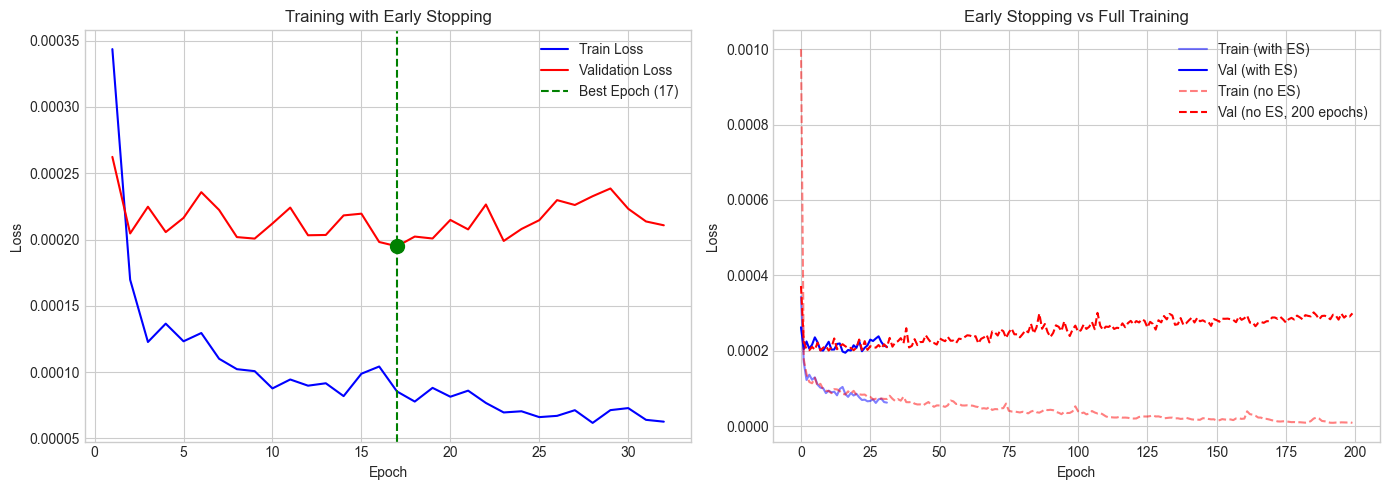


📊 Early Stopping Benefits:
   • Reduced training time: 32 vs 200 epochs
   • Final Val Loss (ES): 0.000195
   • Final Val Loss (No ES): 0.000299


In [17]:
# Visualize early stopping effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training with early stopping
ax1 = axes[0]
epochs_range = range(1, len(train_losses_es) + 1)
ax1.plot(epochs_range, train_losses_es, 'b-', label='Train Loss')
ax1.plot(epochs_range, val_losses_es, 'r-', label='Validation Loss')
ax1.axvline(x=best_epoch + 1, color='green', linestyle='--', label=f'Best Epoch ({best_epoch + 1})')
ax1.scatter([best_epoch + 1], [val_losses_es[best_epoch]], color='green', s=100, zorder=5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training with Early Stopping')
ax1.legend()

# Plot 2: Compare with/without early stopping
ax2 = axes[1]

# Train without early stopping for comparison
model_no_es = MLPNoNorm(input_dim, hidden_dims=[128, 64, 32]).to(device)
train_no_es, val_no_es = train_model(model_no_es, train_loader, val_loader, epochs=200, verbose=False)

ax2.plot(train_losses_es, 'b-', alpha=0.5, label='Train (with ES)')
ax2.plot(val_losses_es, 'b-', label='Val (with ES)')
ax2.plot(train_no_es, 'r--', alpha=0.5, label='Train (no ES)')
ax2.plot(val_no_es, 'r--', label='Val (no ES, 200 epochs)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Early Stopping vs Full Training')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📊 Early Stopping Benefits:")
print(f"   • Reduced training time: {len(train_losses_es)} vs 200 epochs")
print(f"   • Final Val Loss (ES): {val_losses_es[best_epoch]:.6f}")
print(f"   • Final Val Loss (No ES): {val_no_es[-1]:.6f}")

---

## 8. Practical: Fully Regularized MLP for SPY Prediction

Now we combine all regularization techniques into a production-ready model:

1. **L2 Regularization** via weight decay
2. **Dropout** after hidden layers
3. **Layer Normalization** for stability
4. **Early Stopping** to prevent overfitting

### European Quant Fund Best Practices
- Multiple regularization techniques often work synergistically
- Hyperparameter tuning should be done on validation set
- Always test on truly out-of-sample data

In [18]:
class RegularizedTradingMLP(nn.Module):
    """
    Production-ready MLP with multiple regularization techniques.
    
    Architecture:
    - Layer Normalization for stable training
    - Dropout for regularization
    - Residual connections for gradient flow (optional)
    """
    
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], 
                 dropout_rate=0.3, output_dim=1):
        super(RegularizedTradingMLP, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.input_norm = nn.LayerNorm(hidden_dims[0])
        self.input_dropout = nn.Dropout(dropout_rate)
        
        self.hidden_layers = nn.ModuleList()
        self.hidden_norms = nn.ModuleList()
        self.hidden_dropouts = nn.ModuleList()
        
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.hidden_norms.append(nn.LayerNorm(hidden_dims[i+1]))
            self.hidden_dropouts.append(nn.Dropout(dropout_rate))
        
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Xavier initialization for better convergence."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, x):
        # Input layer
        x = self.input_layer(x)
        x = self.input_norm(x)
        x = torch.relu(x)
        x = self.input_dropout(x)
        
        # Hidden layers
        for linear, norm, dropout in zip(self.hidden_layers, self.hidden_norms, self.hidden_dropouts):
            x = linear(x)
            x = norm(x)
            x = torch.relu(x)
            x = dropout(x)
        
        # Output layer (no activation for regression)
        x = self.output_layer(x)
        return x


def train_regularized_model(model, train_loader, val_loader, max_epochs=300,
                            lr=0.001, weight_decay=1e-4, patience=20):
    """
    Complete training pipeline with all regularization techniques.
    """
    criterion = nn.MSELoss()
    
    # L2 regularization via weight decay in optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                      factor=0.5, patience=10, verbose=True)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    train_losses = []
    val_losses = []
    learning_rates = []
    
    for epoch in range(max_epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            
            # Gradient clipping (additional regularization)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                val_loss += criterion(predictions, y_batch).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Track learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Update scheduler
        scheduler.step(avg_val_loss)
        
        # Early stopping
        early_stopping(avg_val_loss, model, epoch)
        
        if early_stopping.early_stop:
            print(f"\n✓ Early stopping at epoch {epoch + 1}")
            break
        
        if (epoch + 1) % 25 == 0:
            print(f"Epoch {epoch+1}: Train={avg_train_loss:.6f}, Val={avg_val_loss:.6f}, LR={current_lr:.6f}")
    
    # Restore best weights
    model.load_state_dict(early_stopping.best_weights)
    
    return train_losses, val_losses, learning_rates, early_stopping.best_epoch

print("✓ RegularizedTradingMLP and training pipeline defined")

✓ RegularizedTradingMLP and training pipeline defined


In [19]:
# Train the fully regularized model
print("=" * 60)
print("Training Fully Regularized Trading MLP")
print("=" * 60)
print("\nRegularization techniques:")
print("  • L2 regularization (weight_decay=1e-4)")
print("  • Dropout (rate=0.3)")
print("  • Layer Normalization")
print("  • Early Stopping (patience=20)")
print("  • Learning Rate Scheduling")
print("  • Gradient Clipping (max_norm=1.0)")
print("\n")

# Create model
regularized_model = RegularizedTradingMLP(
    input_dim=input_dim,
    hidden_dims=[128, 64, 32],
    dropout_rate=0.3
).to(device)

# Count parameters
total_params = sum(p.numel() for p in regularized_model.parameters())
print(f"Model parameters: {total_params:,}")

# Train
train_losses_reg, val_losses_reg, lrs, best_epoch_reg = train_regularized_model(
    regularized_model, train_loader, val_loader,
    max_epochs=300, lr=0.001, weight_decay=1e-4, patience=20
)

print(f"\n✓ Training complete. Best epoch: {best_epoch_reg + 1}")

Training Fully Regularized Trading MLP

Regularization techniques:
  • L2 regularization (weight_decay=1e-4)
  • Dropout (rate=0.3)
  • Layer Normalization
  • Early Stopping (patience=20)
  • Learning Rate Scheduling
  • Gradient Clipping (max_norm=1.0)


Model parameters: 12,737


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
# Evaluate on test set
regularized_model.eval()

with torch.no_grad():
    test_predictions = regularized_model(X_test_tensor).cpu().numpy().flatten()

test_actual = y_test

# Calculate metrics
test_mse = mean_squared_error(test_actual, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_actual, test_predictions)
test_r2 = r2_score(test_actual, test_predictions)

# Directional accuracy
direction_correct = np.sum(np.sign(test_predictions) == np.sign(test_actual))
directional_accuracy = direction_correct / len(test_actual)

print("\n" + "=" * 60)
print("Test Set Performance (Out-of-Sample)")
print("=" * 60)
print(f"MSE:  {test_mse:.8f}")
print(f"RMSE: {test_rmse:.6f} ({test_rmse * 100:.4f}%)")
print(f"MAE:  {test_mae:.6f} ({test_mae * 100:.4f}%)")
print(f"R²:   {test_r2:.4f}")
print(f"\nDirectional Accuracy: {directional_accuracy:.2%}")
print(f"(Baseline random: 50%)")

In [ ]:
# Comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Plot 1: Training curves
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(train_losses_reg, 'b-', label='Train Loss', alpha=0.7)
ax1.plot(val_losses_reg, 'r-', label='Validation Loss')
ax1.axvline(x=best_epoch_reg, color='green', linestyle='--', 
            label=f'Best Epoch ({best_epoch_reg + 1})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training & Validation Loss')
ax1.legend()

# Plot 2: Learning rate schedule
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(lrs, 'g-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule (ReduceLROnPlateau)')
ax2.set_yscale('log')

# Plot 3: Predictions vs Actual
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(test_actual * 100, test_predictions * 100, alpha=0.3, s=10)
ax3.plot([-3, 3], [-3, 3], 'r--', label='Perfect Prediction')
ax3.set_xlabel('Actual Return (%)')
ax3.set_ylabel('Predicted Return (%)')
ax3.set_title(f'Predictions vs Actual (R² = {test_r2:.4f})')
ax3.legend()
ax3.set_xlim(-3, 3)
ax3.set_ylim(-3, 3)

# Plot 4: Cumulative returns (strategy vs buy-and-hold)
ax4 = fig.add_subplot(2, 2, 4)

# Strategy: Long when predicted return > 0, otherwise flat (no shorting)
positions = np.where(test_predictions > 0, 1, 0)
strategy_returns = positions * test_actual
cumulative_strategy = (1 + strategy_returns).cumprod()
cumulative_buyhold = (1 + test_actual).cumprod()

ax4.plot(cumulative_buyhold, 'b-', label='Buy & Hold SPY')
ax4.plot(cumulative_strategy, 'g-', label='Model Strategy')
ax4.set_xlabel('Trading Day')
ax4.set_ylabel('Cumulative Return')
ax4.set_title('Strategy Performance (Test Period)')
ax4.legend()

plt.tight_layout()
plt.show()

# Calculate strategy metrics
strategy_total_return = (cumulative_strategy.iloc[-1] if hasattr(cumulative_strategy, 'iloc') else cumulative_strategy[-1]) - 1
buyhold_total_return = (cumulative_buyhold.iloc[-1] if hasattr(cumulative_buyhold, 'iloc') else cumulative_buyhold[-1]) - 1

print(f"\n📊 Strategy Comparison (Test Period):")
print(f"   Buy & Hold Return: {buyhold_total_return:.2%}")
print(f"   Strategy Return:   {strategy_total_return:.2%}")

---

## 9. Summary: Regularization Best Practices for Trading

### Regularization Technique Selection Guide

| Technique | When to Use | Typical Values |
|-----------|------------|----------------|
| **L2 (Weight Decay)** | Always as baseline | 1e-4 to 1e-2 |
| **L1** | When feature sparsity is desired | 1e-5 to 1e-3 |
| **Dropout** | Deep networks, limited data | 0.1 to 0.5 |
| **LayerNorm** | Trading models (batch-size independent) | — |
| **BatchNorm** | Large batch training, computer vision | — |
| **Early Stopping** | Always | Patience 10-30 |

### European Regulatory Considerations (ESMA MiFID II)

- Document regularization choices and their justification
- Maintain clear separation of training/validation/test data
- Log all hyperparameter tuning experiments
- Regular model validation and performance monitoring

### Key Takeaways

1. **Overfitting in finance is costly** — always prioritize out-of-sample performance
2. **Combine multiple techniques** — they often work synergistically
3. **Layer Normalization** is preferred over Batch Normalization for trading
4. **Early Stopping** is free regularization — always use it
5. **Directional accuracy** often matters more than MSE in trading
6. **Monte Carlo Dropout** provides uncertainty estimates for position sizing

In [ ]:
# Final summary: Compare all models
print("\n" + "=" * 70)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 70)

# Evaluate all models on test set
def evaluate_model(model, name):
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy().flatten()
    
    mse = mean_squared_error(y_test, preds)
    dir_acc = np.mean(np.sign(preds) == np.sign(y_test))
    return {'name': name, 'mse': mse, 'dir_acc': dir_acc}

# Collect results from different experiments
final_results = [
    evaluate_model(results['No Regularization']['model'], 'No Regularization'),
    evaluate_model(results['L2 (λ=1e-4)']['model'], 'L2 Only'),
    evaluate_model(dropout_results[0.4]['model'], 'Dropout Only (0.4)'),
    evaluate_model(norm_results['Layer Normalization']['model'], 'LayerNorm Only'),
    evaluate_model(regularized_model, 'Fully Regularized'),
]

# Display comparison table
print(f"\n{'Model':<25} {'Test MSE':<15} {'Dir. Accuracy':<15}")
print("-" * 55)
for r in final_results:
    print(f"{r['name']:<25} {r['mse']:<15.8f} {r['dir_acc']:<15.2%}")

print("\n" + "=" * 70)
print("✓ Day 3 Complete: Regularization Techniques for Trading Models")
print("=" * 70)

---

## 10. Exercises

### Exercise 1: Hyperparameter Search
Implement a grid search over dropout rates and weight decay values. Find the optimal combination for SPY prediction.

### Exercise 2: MC Dropout Position Sizing
Modify the strategy to size positions inversely proportional to prediction uncertainty from Monte Carlo Dropout.

### Exercise 3: Walk-Forward Validation
Implement walk-forward validation with re-training. Compare with the static train/test split approach.

### Exercise 4: Elastic Net Regularization
Experiment with different L1/L2 ratios in Elastic Net. Which ratio works best for your feature set?

### Exercise 5: European Market Application
Apply the regularized model to European indices (DAX, CAC40, FTSE100). Compare regularization effectiveness across markets.

---

**Next:** Day 4 - Optimizers and Learning Rate Scheduling